In [ ]:

# What version of Python do you have?
import sys

import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf

print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

In [ ]:
import keras

In [1]:
%run __init__.py

In [ ]:
import tensorflow

In [1]:
import pandas as pd
import numpy as np
from joblib import dump, load
# from word2vec import make_model, class_weights_ohe
from plot import Ploty
# import keras
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
# from gensim.models import Word2Vec

ModuleNotFoundError: No module named 'plot'

In [4]:
apple_news_df = pd.read_csv('./data/apple_news_cleaned.csv.gz')

## MODELING

In [5]:
sentences = apple_news_df['text'].apply(lambda x: x.split()).to_list()
max_lenght = 100

In [6]:
l_encoder = LabelEncoder()
y_encoded = l_encoder.fit_transform(apple_news_df['sentiment'])

In [7]:
ohe = OneHotEncoder(sparse=False)
y_ohe = ohe.fit_transform(apple_news_df['sentiment'].values.reshape(-1,1))

In [8]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(apple_news_df['text'])
sequences = tokenizer.texts_to_sequences(apple_news_df['text'])
word_index = tokenizer.word_index
# total vocabulary size plus 0 for unknown words
vocab_size = len(tokenizer.word_index) + 1
data = pad_sequences(sequences, max_lenght)
labels = to_categorical(y_encoded)

In [9]:
print(f"{'Unique Words':25} {len(tokenizer.index_word)}")
print(f"{'Shape of data tensor':25} {data.shape}")
print(f"{'Shape of label tensor':25} {labels.shape}")

Unique Words              36867
Shape of data tensor      (9520, 100)
Shape of label tensor     (9520, 3)


In [10]:
word2vec = Word2Vec(sentences,
                     vector_size=max_lenght,
                     window=5,
                     min_count=1,
                     workers=4,
                    )
word2vec.train(sentences, total_examples=word2vec.corpus_count, epochs=5)
pretrained_weights = word2vec.wv.vectors
vocab_size, emdedding_size = pretrained_weights.shape
vectors = np.asarray(word2vec.wv.vectors)

In [11]:
word2vec.save('./word2vec/word2vrc_model')

In [11]:
len(word_index), len(word2vec.wv.key_to_index)

(36867, 36867)

In [12]:
embedding_matrix = np.zeros((vocab_size+1, emdedding_size))
for word, idx in word_index.items():
        embedding_matrix[idx] = word2vec.wv[word]

In [13]:
dump(embedding_matrix, './word2vec/embedding_matrix.pkl', compress=5)

['./word2vec/embedding_matrix.pkl']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=.15, random_state=1, stratify=labels)
X_train, X_val, y_train, y_val   = train_test_split(data, labels, test_size=.15, random_state=1, stratify=labels)

print(f"Train\n\t{'X :':5}{X_train.shape}\n\t{'Y :':5}{y_train.shape}")
print(f"Test\n\t{'X :':5}{X_test.shape}\n\t{'Y :':5}{y_test.shape}")
print(f"Validation\n\t{'X :':5}{X_val.shape}\n\t{'Y :':5}{y_val.shape}")

Train
	X :  (8092, 100)
	Y :  (8092, 3)
Test
	X :  (1428, 100)
	Y :  (1428, 3)
Validation
	X :  (1428, 100)
	Y :  (1428, 3)


In [15]:
input_dim = embedding_matrix.shape[0]
embedding_dim = embedding_matrix.shape[1]
max_seq_len = data.shape[1]

In [88]:
BIAS = class_weights_ohe(labels)
WEIGHTS = {k:v for k,v in enumerate(BIAS)}
METRICS = ['accuracy']
EPOCHS = 32
BATCH_SIZE = 400
STEPS_x_EPOCH = X_train.shape[0]//BATCH_SIZE

In [18]:
eStop_Val_Loss = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=12,
                            verbose=1,mode='min',baseline=0.999,restore_best_weights=False)
eStop_Loss     = EarlyStopping(monitor='loss', min_delta=0.001, patience=12,
                            verbose=1,mode='min',baseline=0.999,restore_best_weights=False)
eStop_Accuracy = EarlyStopping(monitor='accuracy', min_delta=0.001, patience=24,
                            verbose=1, mode='max', baseline=0.999, restore_best_weights=False)
eStop_Val_accuracy  = EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=24,
                            verbose=1, mode='max', baseline=0.999, restore_best_weights=False)

eStop_Reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=8, min_lr=0.000001, verbose=1)

In [167]:
keras.backend.clear_session()

In [168]:
%run './lib/word2vec.py'

In [19]:
plot_model = Ploty()

In [93]:
keras.backend.clear_session()

In [94]:
model = make_model(metrics=METRICS,
                   input_dim=input_dim,
                   embedding_dim=embedding_dim,
                   weights=embedding_matrix,
                   input_length=max_seq_len,
                  )

In [95]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          3686800   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 200)          160800    
_________________________________________________________________
lstm_2 (LSTM)                (None, 16)                13888     
_________________________________________________________________
dense16 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
output4 (Dense)              (None, 3)                 51        
Total params: 3,861,811
Trainable params: 175,011
Non-trainable params: 3,686,800
______________________________________

In [98]:
model.layers[-1].bias=BIAS
model.layers[0].embeddings_initializer = keras.initializers.glorot_uniform()

In [99]:
BATCH_SIZE, EPOCHS = 400, 48

In [100]:
history = model.fit(X_train,
                    y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
#                     callbacks=[eStop_Val_accuracy, eStop_Val_Loss],
                    validation_split=0.1,                    
                    validation_data=(X_val, y_val),
                    class_weight=None,
                    sample_weight=None,
#                     steps_per_epoch=STEPS_x_EPOCH,
#                     validation_steps=20,
#                     validation_freq=1,
                    workers=6,
                    use_multiprocessing=True
                    )

Train on 8092 samples, validate on 1428 samples
Epoch 1/48
8092/8092 [==============================] - 48s 6ms/step - loss: 1.0634 - accuracy: 0.4462 - val_loss: 1.0286 - val_accuracy: 0.5056
Epoch 2/48
8092/8092 [==============================] - 42s 5ms/step - loss: 1.0384 - accuracy: 0.4764 - val_loss: 1.0151 - val_accuracy: 0.5168
Epoch 3/48
8092/8092 [==============================] - 42s 5ms/step - loss: 1.0248 - accuracy: 0.4848 - val_loss: 1.0111 - val_accuracy: 0.5154
Epoch 4/48
8092/8092 [==============================] - 41s 5ms/step - loss: 1.0156 - accuracy: 0.4886 - val_loss: 1.0035 - val_accuracy: 0.5245
Epoch 5/48
8092/8092 [==============================] - 41s 5ms/step - loss: 1.0102 - accuracy: 0.4965 - val_loss: 0.9968 - val_accuracy: 0.5287
Epoch 6/48
8092/8092 [==============================] - 41s 5ms/step - loss: 0.9965 - accuracy: 0.5061 - val_loss: 0.9931 - val_accuracy: 0.5301
Epoch 7/48
8092/8092 [==============================] - 40s 5ms/step - loss: 0.989

In [113]:
model.save_weights('./word2vec/mc/multiclass_1')

In [116]:
history = model.fit(X_train,
                    y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    callbacks=[eStop_Reduce_lr],
                    validation_split=0.1,                    
                    validation_data=(X_val, y_val),
                    class_weight=None,
                    sample_weight=None,
                    workers=6,
                    use_multiprocessing=True
                    )

Train on 8092 samples, validate on 1428 samples
Epoch 1/48
8092/8092 [==============================] - 42s 5ms/step - loss: 0.4554 - accuracy: 0.8238 - val_loss: 1.2946 - val_accuracy: 0.6485
Epoch 2/48
8092/8092 [==============================] - 41s 5ms/step - loss: 0.4376 - accuracy: 0.8361 - val_loss: 1.2674 - val_accuracy: 0.6471
Epoch 3/48
8092/8092 [==============================] - 42s 5ms/step - loss: 0.4405 - accuracy: 0.8347 - val_loss: 1.2718 - val_accuracy: 0.6541
Epoch 4/48
8092/8092 [==============================] - 42s 5ms/step - loss: 0.4195 - accuracy: 0.8403 - val_loss: 1.3384 - val_accuracy: 0.6436
Epoch 5/48
8092/8092 [==============================] - 40s 5ms/step - loss: 0.4288 - accuracy: 0.8366 - val_loss: 1.3095 - val_accuracy: 0.6478
Epoch 6/48
8092/8092 [==============================] - 40s 5ms/step - loss: 0.4192 - accuracy: 0.8419 - val_loss: 1.4186 - val_accuracy: 0.6387
Epoch 7/48
8092/8092 [==============================] - 42s 5ms/step - loss: 0.425

KeyboardInterrupt: 

In [264]:
score = model.evaluate(X_test, y_test, batch_size=1, steps=X_test.shape[0], workers=8, verbose=0)

In [269]:
y_pred = model.predict(X_test, batch_size=1,verbose=0)

In [572]:
print('Accuracy :', score[1])

Accuracy : 0.928067684173584


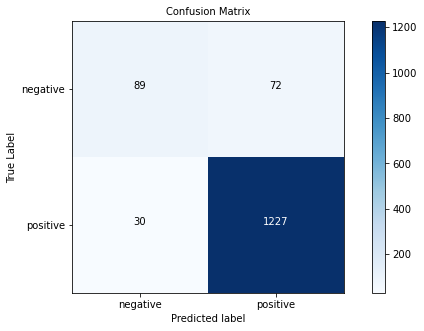

In [571]:
plot_model.confusion_matrix(y_true=y_test, y_pred=y_pred, target_name=ohe.categories_[0], file_name='./img/cm.jpg')

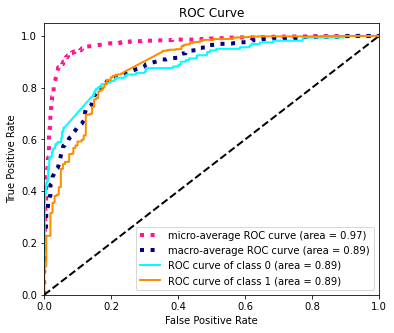

In [573]:
plot_model.plot_roc_curve(y_true=y_test, y_pred=y_pred, file_name='./img/roc.jpg')